In [46]:
#importing all the librairy / header files
from copy import deepcopy
import numpy as np

import scipy.io as sio #for input from mat file
import itertools #dependency for confusion matrix

from matplotlib import pyplot as plt#for plotting graphs
from sklearn.cluster import MiniBatchKMeans,KMeans 
from sklearn import preprocessing #for feature scaling
from sklearn.decomposition import PCA # for PCA (dimensionality reduction)

from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [47]:
#splits the numpy array into two parts accoding to the condintion cond
def split(arr, cond):
  return [arr[cond], arr[~cond]]

In [48]:
#taking input ( 286 dim feature vector) fromamt files generated by matlab preprocessing code
#the matlab code is taken from http://vision.cs.uiuc.edu/projects/activity/
#special thanks to Du Tran, Alexander Sorokin, and David Forsyth 
#for provding the code in their website under open source liscence
cam0_label = sio.loadmat('IXMAS\IXMAS_cam0_labels.mat')
cam0_feature = sio.loadmat('IXMAS\IXMAS_cam0_win_feature.mat')
cam1_label = sio.loadmat('IXMAS\IXMAS_cam1_labels.mat')
cam1_feature = sio.loadmat('IXMAS\IXMAS_cam1_win_feature.mat')
cam2_label = sio.loadmat('IXMAS\IXMAS_cam2_labels.mat')
cam2_feature = sio.loadmat('IXMAS\IXMAS_cam2_win_feature.mat')
cam3_label = sio.loadmat('IXMAS\IXMAS_cam3_labels.mat')
cam3_feature = sio.loadmat('IXMAS\IXMAS_cam3_win_feature.mat')
cam4_label = sio.loadmat('IXMAS\IXMAS_cam4_labels.mat')
cam4_feature = sio.loadmat('IXMAS\IXMAS_cam4_win_feature.mat')


In [49]:
#extrating mat file contents to numpy array
cam0_l = cam0_label['labels']
cam1_l = cam1_label['labels']
cam2_l = cam2_label['labels']
cam3_l = cam3_label['labels']
cam4_l = cam4_label['labels']
cam0_f = cam0_feature['win_feature']
cam1_f = cam1_feature['win_feature']
cam2_f = cam2_feature['win_feature']
cam3_f = cam3_feature['win_feature']
cam4_f = cam4_feature['win_feature']

#each of the cam<i>_l_train and cam<i>_f_train contains actions performed by first 7 actors 
cam0_l_train , cam0_l_test = split(cam0_l , cam0_l[:, 0]<22)
cx , cy = np.shape(cam0_l_train)
cam0_f_train = cam0_f[:cx ,:]
cam0_f_test = cam0_f[cx: , :]

cam1_l_train , cam1_l_test = split(cam1_l , cam1_l[:, 0]<22)
cx , cy = np.shape(cam1_l_train)
cam1_f_train = cam1_f[:cx ,:]
cam1_f_test = cam1_f[cx: , :]

cam2_l_train , cam2_l_test = split(cam2_l , cam2_l[:, 0]<22)
cx , cy = np.shape(cam2_l_train)
cam2_f_train = cam2_f[:cx ,:]
cam2_f_test = cam2_f[cx: , :]

cam3_l_train , cam3_l_test = split(cam3_l , cam3_l[:, 0]<22)
cx , cy = np.shape(cam3_l_train)
cam3_f_train = cam3_f[:cx ,:]
cam3_f_test = cam3_f[cx: , :]

cam4_l_train , cam4_l_test = split(cam4_l , cam4_l[:, 0]<22)
cx , cy = np.shape(cam4_l_train)
cam4_f_train = cam4_f[:cx ,:]
cam4_f_test = cam4_f[cx: , :]

#each of the cam<i>_l_test and cam<i>_f_test contains actions performed by actors 8, 9 ,10 
cam0_l_test , cam_l_dummy = split(cam0_l_test , cam0_l_test[:, 0]<31)
cx , cy = np.shape(cam0_l_test)
cam0_f_test = cam0_f_test[:cx ,:]
cam_f_dummy = cam0_f_test[cx: , :]

cam1_l_test , cam_l_dummy = split(cam1_l_test , cam1_l_test[:, 0]<31)
cx , cy = np.shape(cam1_l_test)
cam1_f_test = cam1_f_test[:cx ,:]
cam_f_dummy = cam1_f_test[cx: , :]

cam2_l_test , cam_l_dummy = split(cam2_l_test , cam2_l_test[:, 0]<31)
cx , cy = np.shape(cam2_l_test)
cam2_f_test = cam2_f_test[:cx ,:]
cam_f_dummy = cam2_f_test[cx: , :]

cam3_l_test , cam_l_dummy = split(cam3_l_test , cam3_l_test[:, 0]<31)
cx , cy = np.shape(cam3_l_test)
cam3_f_test = cam3_f_test[:cx ,:]
cam_f_dummy = cam3_f_test[cx: , :]

cam4_l_test , cam_l_dummy = split(cam4_l_test , cam4_l_test[:, 0]<31)
cx , cy = np.shape(cam4_l_test)
cam4_f_test = cam4_f_test[:cx ,:]
cam_f_dummy = cam4_f_test[cx: , :]


print(np.shape(cam0_f_train))
print(np.shape(cam1_f_train))
print(np.shape(cam2_f_train))
print(np.shape(cam3_f_train))
print(np.shape(cam4_f_train))
print(np.shape(cam0_f_test))
print(np.shape(cam1_f_test))
print(np.shape(cam2_f_test))
print(np.shape(cam3_f_test))
print(np.shape(cam4_f_test)) 


(24653, 286)
(24675, 286)
(24696, 286)
(24716, 286)
(24736, 286)
(10104, 286)
(10113, 286)
(10122, 286)
(10131, 286)
(10140, 286)


# feature reorganization
>* now need to group features ( from all cameras ) of each class( action category) seperatly<br>
>* making a list of dimensions 14 * n * 286 ( [action_i][number of frames] [ features])<br> 
> where n is the number of frames belonging to action_i<br>
>* we make an list feature_per_class which is of the form
>> feature_per_class [ i ] [ j ] = feature vector of jth frame of the action number i <br>
>> label_per_class [ i ] [ j ] = correctlabel of jth frame of the action number i 

In [50]:
#function to perform the feature reorganization described above 
def extract_features_per_class( cam_l , cam_f , feature_per_class , label_per_class):
    j = 0 ;
    for i in cam_l:
        feature_per_class[ i[1] ].append( cam_f[j] ) ;
        label_per_class[ i[1] ].append( cam_l[j] ) ;
        j += 1 ;

In [51]:
total_class = 14
feature_per_class = [[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
label_per_class = [[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
extract_features_per_class( cam0_l_train ,cam0_f_train , feature_per_class ,label_per_class)
extract_features_per_class( cam1_l_train ,cam1_f_train , feature_per_class ,label_per_class)
extract_features_per_class( cam2_l_train ,cam2_f_train , feature_per_class ,label_per_class )
extract_features_per_class( cam3_l_train ,cam3_f_train , feature_per_class ,label_per_class)
extract_features_per_class( cam4_l_train ,cam4_f_train , feature_per_class ,label_per_class)


In [52]:
#checking how many frames belong to each class
#for i in feature_per_class:
    #print(len(i))

### To build the dictionary of keyposes-
- the feature descriptors for every fourth frame in the training data are clustered via the mini batch k-means - algorithm.<br>
- For these experiments, k was set to 200 clusters per class.<br> 
- We initialized k-means 5 times and selected the cluster assignment with minimum error, as measured by average intra-class similarity.<br>
- We choose K = 2600 for IXMAS.<br>
Input:<br>
feature vector for all frames of all videos<br>
Output:<br>
Key poses and their weights <br>
Let 𝑘 represents the number of clusters,<br>
𝐴 = {𝑎1,𝑎2,...𝑎𝑟}be the set of actions,<br>
𝑝𝑖𝑗 denotes 𝑗 − 𝑡ℎ key pose of action 𝑖 and 𝑤𝑖𝑗 be the its weight <br>
> 1: for all action 𝑎 ∈ 𝐴 do <br>
2: 		Cluster all frames into k groups using k-means <br>
3: 		Take cluster centers as keyposes thus ending up with 𝑟×𝑘 key poses <br> 
4: endfor <br>

In [53]:
keyposes = []#to store all the keyposes belong to class i
total_cluster = 0 
#implementing perclass mini batch k-means
for i in range(0,14):
    k = 200 ;
    total_cluster+=k
    X = np.array(feature_per_class[i])
    # Number of clusters
    kmeans = MiniBatchKMeans(init = 'random' , n_clusters=k)
    # Fitting the input data
    kmeans = kmeans.fit(X)
    # Getting the cluster labels
    labels = kmeans.predict(X)
    # Centroid values
    centroids = kmeans.cluster_centers_
    print ( kmeans.inertia_ ) ;#printing error associated with each class
    keyposes.append(centroids)
    #np.concatenate((keyposes , centroids) , axis = 0); 


123343.574914
25438.3942054
27989.2261825
33970.4486998
28872.471972
33235.9417539
34455.8209734
51303.7147523
30270.7499059
26942.4243053
38650.9664609
35609.1492988
24141.5029225
19071.1355821


In [54]:
#we can control on what actions we need to implement our method by below variables
start = 1 #starting action number
endd = 13 #ending action number

In [55]:
#input- feature vetor of a frame 
#output- keypose alloted to the frame along with error associated and actual list of 286 points describing the keypose
def get_keypose(frame_ij):#returns keypose_action , keypose_num , error , actual_keypose
    keypose_in = 0 
    dist = np.linalg.norm(frame_ij - keyposes[start][0])
    keypose_temp = [start, 0,dist,keyposes[start][0]]
    cnt = 0
    for k in keyposes:
        if cnt >= start and cnt<=endd:
            keypose_num = 0
            for l in k:
                if dist > abs(np.linalg.norm(frame_ij - l)):
                    dist = abs(np.linalg.norm(frame_ij - l))
                    keypose_temp = [keypose_in , keypose_num,dist,l]
                keypose_num = keypose_num +1
        keypose_in = keypose_in + 1
        cnt+=1
    return keypose_temp 
# keypose_temp = [ action_number  , keypose number of that action , error]

In [56]:
#alloting each frame of a action to keypose
#here we are obtaining keyposes alloted to each frame of each class and storing it in list alloted_keypose 
error = 0
alloted_keypose =  [[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

#alloted keypose has for each action keypose alloted
for action_ in range(start,endd+1):
    cnt = 0
    list_for_action = []#stores list of keypose_temp for each frame for action action_
    for j in feature_per_class[action_]:
        #j is frame_ij
        keypose_temp = get_keypose(j)    
        list_for_action.append( keypose_temp )
        error += keypose_temp[2]
        #print(action_,cnt,sep='\t')
        cnt+=1
    alloted_keypose[ action_ ].append(list_for_action)
#print(error)

In [57]:
#printing the final error obtained after all the allotment
print(error)

192957.534151


In [58]:
#hashing/counting  all the frames of a action alloted to a particular keypose
keypose_statistics = np.zeros((14,200,14))#will store for keypose_statistics[action][keypose_number][action]
#the above variable will store for each keypose how many frames are alloted to it for each action
action_number = 0
for i in alloted_keypose:#starting to watch allotment from action 1
    #if len(i) > 0:
    cnt = 0 
    for j in i:
 
        for kk in j:# kk is keypose temp
            cnt+=1
            keypose_statistics[kk[0]][kk[1]][action_number]+=1
   
    action_number+=1

In [59]:
#studying and analyzing for each keypose , the  number of frames of an action assigned to it

for i in range(0,14):
    print('keyposes belong to action = ',i)
    sum1 = 0
    sum2 = np.zeros((1,14))
    cnt = 0
    for j in range(0,200):
        summ = np.sum(keypose_statistics[i][j][:])
        if summ>0:
            sum1 += summ
            for k in range(0,14):
                sum2[0][k]+=keypose_statistics[i][j][k]
            #print(cnt,keypose_statistics[i][j][start:endd+1],sep='\t')
        cnt+=1
    #print('keyposes belonging to actions',i,' have = ',sum1,'frames',sep='\t')
    #print(sum2)
    #print(np.max(sum2)/sum1)

keyposes belong to action =  0
keyposes belong to action =  1
keyposes belong to action =  2
keyposes belong to action =  3
keyposes belong to action =  4
keyposes belong to action =  5
keyposes belong to action =  6
keyposes belong to action =  7
keyposes belong to action =  8
keyposes belong to action =  9
keyposes belong to action =  10
keyposes belong to action =  11
keyposes belong to action =  12
keyposes belong to action =  13


In [60]:
print(keypose_statistics[2][100])

[  0.   2.  10.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


## keypose learing
>The class-discriminative power of each keypose is estimated<br>
>by the distribution P(xk | y), which is computed from<br>
>the training data using Laplace smoothing:<br>
>>#### P(xk | y) = (ND + 1) / (NA + K)<br>
>where NA is the total number of training frames with label y<br>
>and ND is the size of the subset of those frames assigned to<br>
>keypose xk .Akeypose, xk , is considered class-discriminative<br>
>if the correct label, y∗, is most likely, i.e.,<br> 
>>>#### argmax (y)    P(xk | y ) = y∗.

In [61]:
#calculating the above probabity and storing in probability_keypose
probability_keypose = np.zeros(( 14,200 , 14))

#argmx stores for all the keypose the action number for which it has the highest above probabiliy
#argmx [ i] [ j ]  = for all k : max(  probability_keypose[ i ] [ j ] [ k ])

argmx = [[[] for i in range ( 0 , 200 ) ] for j in range(0,14)] ;

total_cluster = (endd-start+1)*200;



for keypose_index in range ( 0 , 14 ):
    for keypose_num in range ( 0 , 200 ) :
        mx_prob = 0.0 ;
        for action_y in range(0,14,1) :
            if (action_y < start or action_y > endd ) :
                continue ;
            probability_keypose[ keypose_index ][keypose_num][ action_y ] = ( keypose_statistics[keypose_index][keypose_num][ action_y ] + 1)
            probability_keypose[ keypose_index ][keypose_num][ action_y ] /= ( len(feature_per_class[action_y]) + total_cluster ) 
            if ( probability_keypose[keypose_index][keypose_num][action_y] > mx_prob ) :
                argmx[keypose_index][keypose_num] = [action_y] ;
                mx_prob = probability_keypose[keypose_index][keypose_num][action_y] ;
            elif ( probability_keypose[keypose_index][keypose_num][action_y] == mx_prob ) :
                argmx[keypose_index][keypose_num].append ( action_y ) ;
        indices = np.where(probability_keypose[keypose_index][keypose_num] == probability_keypose[keypose_index][keypose_num] .max())
        #if keypose_index!=indices[0][0] and keypose_index>=start and keypose_index<=endd:
        #    print(keypose_index , indices[0], sep='\t')

In [62]:
#organizing dataset making for the Q-learing 
#run cell 2 first and then this
#each of the cam<i>_l_train and cam<i>_f_train will contain all the frames for all the actions in range 
#[ start , endd ] for actors 1 to 7 


start = start
finish = endd

cam_f_train_size = np.shape( cam0_f_train )[0] ;

new_feature = [] ;
new_label = [] ;

for i in range ( cam_f_train_size ) :
    if ( cam0_l_train[i][1] >= start and cam0_l_train[i][1] <= finish ) :
        new_feature.append ( cam0_f_train[i] ) ;
        new_label.append ( cam0_l_train[i] ) ;
cam0_f_train = new_feature ;
cam0_l_train = new_label ;
cam_f_train_size = np.shape( cam1_f_train )[0] ;

new_feature = [] ;
new_label = [] ;
for i in range ( cam_f_train_size ) :
    if ( cam1_l_train[i][1] >= start and cam1_l_train[i][1] <= finish ) :
        new_feature.append ( cam1_f_train[i] ) ;
        new_label.append ( cam1_l_train[i] ) ;
cam1_f_train = new_feature ;
cam1_l_train = new_label ;

cam_f_train_size = np.shape( cam2_f_train )[0] ;
new_feature = [] ;
new_label = [] ;
for i in range ( cam_f_train_size ) :
    if ( cam2_l_train[i][1] >= start and cam2_l_train[i][1] <= finish ) :
        new_feature.append ( cam2_f_train[i] ) ;
        new_label.append ( cam2_l_train[i] ) ;
cam2_f_train = new_feature ;
cam2_l_train = new_label ;

cam_f_train_size = np.shape( cam3_f_train )[0] ;
new_feature = [] ;
new_label = [] ;
for i in range ( cam_f_train_size ) :
    if ( cam3_l_train[i][1] >= start and cam3_l_train[i][1] <= finish ) :
        new_feature.append ( cam3_f_train[i] ) ;
        new_label.append ( cam3_l_train[i] ) ;
cam3_f_train = new_feature ;
cam3_l_train = new_label ;

cam_f_train_size = np.shape( cam4_f_train )[0] ;
new_feature = [] ;
new_label = [] ;
for i in range ( cam_f_train_size ) :
    if ( cam4_l_train[i][1] >= start and cam4_l_train[i][1] <= finish ) :
        new_feature.append ( cam4_f_train[i] ) ;
        new_label.append ( cam4_l_train[i] ) ;
cam4_f_train = new_feature ;
cam4_l_train = new_label ;
camera_feature = []
camera_label = []
camera_feature.append(cam0_f_train)
camera_feature.append(cam1_f_train)
camera_feature.append(cam2_f_train)
camera_feature.append(cam3_f_train)
camera_feature.append(cam4_f_train)

camera_label.append(cam0_l_train)
camera_label.append(cam1_l_train)
camera_label.append(cam2_l_train)
camera_label.append(cam3_l_train)
camera_label.append(cam4_l_train)
print ( np.shape(cam0_f_train) ) ;
print ( np.shape(cam1_f_train) ) ;
print ( np.shape(cam2_f_train) ) ;
print ( np.shape(cam3_f_train) ) ;
print ( np.shape(cam4_f_train) ) ;

(19979, 286)
(19979, 286)
(19979, 286)
(19979, 286)
(19979, 286)


## reward function
<img src="image.png" style="height:100">


In [63]:
#input - keypose_index , view_shift , actual_label
#retuns the reward associated accoring to the above description
def reward ( keypose_index , v , y_actual ):
    r = 0
    if v[0][0] != 0 or v[0][1] != 0:
        r = -0.1
    f = 0 ;
    for i in argmx[keypose_index[0]][keypose_index[1]] :
        if ( i == y_actual ) :
            f = 1 ;
    if ( f ) :
        r += 1 ;
    else :
        r -= 1 ;
    return r ;

In [64]:
#function to return the max entry of the row belonging to keypose x_ in Q table
def argmax(Q , x_ ):
    maxx = -10000000000000000
    for i in (0 , 25):
        maxx = max ( maxx , Q[x_[0]][x_[1]][i])
    return maxx

## View-shift value learning
<img src="Capture3.PNG" style="height:100">

In [65]:

#Q-learing phase is implemented here
camera_locations = []#it contains all the camera locations as visulaized on a 2 X 10 grid 
camera_locations.append([3 , 0])
camera_locations.append([4 , 0])
camera_locations.append([6 , 0])
camera_locations.append([7 , 0])
camera_locations.append([3 , 1])


Q = np.random.rand(14,200, 26)#initialzing the Q table

view_shift_map = np.zeros((5,5))# this is used to map the view shifts
# view shift from camera i to j is mapped as i*5+j so that on seing this value we can tell from which camera 
# to which camera is the view shift occuring 

#view shift mappign
for i in range( 0 , 5 , 1 ):
    for j in range( 0 , 5 , 1 ):
        view_shift_map[i][j] = i*5 + j  

iterations = 10000#setting the number of iterations

import random#importing the random libreairy of python

#setting the parameter values
learing_rate = 1.0
gamma = 0.5#discount parameter

range_number = np.shape ( camera_feature[0] )[1] ;#determining the max range from which we can chose any 
#random frame for training

while ( iterations > 0 ) :
    
    iterations -= 1
    #randomly choosing the frame number and camera number
    i = random.randint(0,range_number-1)  #frame number
    j = random.randint(0,4) # camera number
    
    frame_ij = camera_feature[j][i] # feature vector of the corresponding frame
    y_actual = camera_label[j][i][1]# actual label of the corresponding frame
    
    keypose_temp  = get_keypose(frame_ij)# find the keypose of the frame
    keypose_in = keypose_temp[0] #
    keypose_num = keypose_temp[1]
    keypose_index = [keypose_in , keypose_num]
    
    #rememeber the function get_keypose returns [keypose_action , keypose_num , error , actual_keypose]
    
    for k in range(0 , 5 ,1 ):
        #making the list representing the view shift
        v = [ [camera_locations[j][0] - camera_locations[k][0] , camera_locations[j][1] - camera_locations[k][1] ] ] 
        #getting the hash value of viewshift from camera j to k 
        cv = view_shift_map[j][k]
        #calculating the reward using above information
        r = reward( keypose_index , v ,y_actual )
        #getting the keypose of the frame which is there in the view after performing the view shift 
        x_index = get_keypose( camera_feature[k][i] )
        
        cv  = int(cv)
        #printing the iteration number the index of the keypose to which we have shifted and the viewshift hash
        #print( "Iteration : " , iterations , x_index[0] ,'  ',x_index[1] , '   ' , cv) ;
        
        #updating the Q table
        Q[ x_index[0] ][ x_index[1] ][ cv ] = ( 1 - learing_rate ) * Q [ x_index[0] ][ x_index[1] ] [ cv ] + learing_rate * ( r + gamma * argmax( Q , x_index ))
   
   

In [66]:
#organizing dataset making for the Q-learing 
#run cell 2 first and then this
#each of the cam<i>_l_test and cam<i>_f_test will contain all the frames for all the actions in range 
#[ start , endd ] for actors 8 to 10 

cam_test_size = np.shape ( cam0_f_test )[0] ;
new_test = [] ;
new_label_test = [] ;
start =  start
finish = endd

for i in range ( cam_test_size ) :
    if ( cam0_l_test[i][1] >= start and cam0_l_test[i][1] <= finish ) :
        new_test.append ( cam0_f_test[i] ) ;
        new_label_test.append ( cam0_l_test[i] ) ;
cam0_f_test = new_test ;
cam0_l_test = new_label_test ;
cam_test_size = np.shape ( cam4_f_test )[0] ;

new_test = [] ;
new_label_test = [] ;
for i in range ( cam_test_size ) :
    if ( cam4_l_test[i][1] >= start and cam4_l_test[i][1] <= finish ) :
        new_test.append ( cam4_f_test[i] ) ;
        new_label_test.append ( cam4_l_test[i] ) ;
cam4_f_test = new_test ;
cam4_l_test = new_label_test ;
cam_test_size = np.shape ( cam1_f_test )[0] ;

new_test = [] ;
new_label_test = [] ;
for i in range ( cam_test_size ) :
    if ( cam1_l_test[i][1] >= start and cam1_l_test[i][1] <= finish ) :
        new_test.append ( cam1_f_test[i] ) ;
        new_label_test.append ( cam1_l_test[i] ) ;
cam1_f_test = new_test ;
cam1_l_test = new_label_test ;
cam_test_size = np.shape ( cam2_f_test )[0] ;

new_test = [] ;
new_label_test = [] ;
for i in range ( cam_test_size ) :
    if ( cam2_l_test[i][1] >= start and cam2_l_test[i][1] <= finish ) :
        new_test.append ( cam2_f_test[i] ) ;
        new_label_test.append ( cam2_l_test[i] ) ;
cam2_f_test = new_test ;
cam2_l_test = new_label_test ;
cam_test_size = np.shape ( cam3_f_test )[0] ;

new_test = [] ;
new_label_test = [] ;
for i in range ( cam_test_size ) :
    if ( cam3_l_test[i][1] >= start and cam3_l_test[i][1] <= finish ) :
        new_test.append ( cam3_f_test[i] ) ;
        new_label_test.append ( cam3_l_test[i] ) ;
cam3_f_test = new_test ;
cam3_l_test = new_label_test ;

cam_f_test = np.array([cam0_f_test , cam1_f_test , cam2_f_test , cam3_f_test, cam4_f_test ]) ;
cam_l_test = np.array([cam0_l_test , cam1_l_test , cam2_l_test , cam3_l_test , cam4_l_test ]) ;

print ( np.shape ( cam_f_test ) ) ;

(5, 8519, 286)


## Dynamic view-shift recognition
<img src="Capture4.PNG" style="height:100">

In [67]:
#inplementing the testing phase 

#function for obtaining the max probability keypose sequence passed
#input  - keypose sequence observed till now and the probility numpy array
#output - the prediction based on the naive bayes using log transformation till now and the probability 
#         with that prefiction

def get_max_y_for_probabilit ( keypose_sequence , probability ) :
    mx = -1e18 ; 
    y_hat = -1 ;
    for j in range(0,14) :
        sum_p = 0.0 ;
        for i in keypose_sequence :
            sum_p = sum_p + np.log(probability[i[0]][i[1]][j]);
        if ( sum_p > mx ) :
            mx = sum_p ;
            y_hat = j ;
    return [y_hat ,mx] ;

#this function returns the max value of the Q table for keypose xk on camera 'a'
def get_max_for_Q_table ( Q , a , xk ) :
    ret_j = -1 ;
    mx = -1e18;
    for j in range ( 0 , 5 ) :
        if ( Q[xk[0]][xk[1]][j*5+a] > mx ) :
            mx = Q[xk[0]][xk[1]][int(j*5+a)] ;
            ret_j = j ;
    return ret_j ;

#randomly choosing the initial camera
a = random.randint(0,4) #active_camera
t = 0 ;#time
keypose_sequence = [] ;#for storing the keypose sequence
mx = -1e18#max value

range_number = np.shape ( cam_f_test[0] )[0] ;
print ( range_number ) ;
correct = 0
incorrect = 0

#for the confusion matrix
y_test1 = []
y_pred1 = []

file_output = open ( "file_output.txt" , "w+" ) ;
file_view_shifts = open ( "file_view_shifts.txt" , "w+" ) ;

correct_prob = []
incorrect_prob = []

while(t<range_number):
    #randomly choose the active camera
    a = random.randint(0,4) #active_camera
    temp_time = t ;
    temp_camera = a ;
    actor = cam_l_test[a][t][0] ;
    label = cam_l_test[a][t][1] ;#correct label
    actor_ = actor ; 
    label_ = label ;
    keypose_sequence = [] ;
    cnt_viewshift = 0 ;
    temp_prob = 0 ;
    
    while ( t < range_number and actor == actor_ and label == label_ ) :
        #while current action sequence does not end
        
        #feature of the current frame
        feature = cam_f_test[a][t]
        
        x_k = get_keypose ( feature ) ;#keypose of the current frame
        keypose_sequence.append ( x_k[:2] ) ;#append it 

        #computing the posterior probabilities, P(y | keypose_sequence ) for naive bayes classification
        y_hat,prob = get_max_y_for_probabilit ( keypose_sequence , probability_keypose )
        
        #get the next camera index for shift
        a = get_max_for_Q_table ( Q , a , x_k ) ;
        
        file_view_shifts.write ( str(a) + " " + str(t) + "\n" ) ;
        cnt_viewshift += 1
        
        if ( a == -1 ) :
            print ( "Error" ) ;
            break ;
        t = t+1 ;
        if ( t >= range_number ) :
            break ;
        actor_ = cam_l_test[a][t][0] ;
        label_ = cam_l_test[a][t][1] ;
        
    file_output.write ( str(temp_camera) + " " + str(temp_time) + " " + str(y_hat) + " " + str(cam_l_test[temp_camera][temp_time][1]) + "  "+str(cnt_viewshift)+"\n" ) ;
    
    #updating the current and incorrect variables
    if ( y_hat == cam_l_test[temp_camera][temp_time][1] ) :
        correct += 1 ;
        correct_prob.append(temp_prob)
        
    else :
       
        incorrect += 1 ;
        incorrect_prob.append(temp_prob)
       
        
    y_test1.append(y_hat)
    y_pred1.append(cam_l_test[temp_camera][temp_time][1])
print ( correct , incorrect ) ;
print(correct/(correct+incorrect))

8519


C:\Users\Aditya\Anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


111 5
0.9568965517241379


In [68]:
#collecting values for printing the confusion matrix
class_names = [' check watch', ' cross arms', ' scratch head', ' sit down', ' get up', ' turn around', ' walk', ' wave', ' punch',' kick', ' point', ' pick up', ' throw (over head)']
y_test = y_test1
y_pred = y_pred1

Confusion matrix, without normalization
[[9 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 9 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 9 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[ 0.9  0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.9  0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.9  0.   0.   0.1  0.   0. ]
 [ 0.   0.

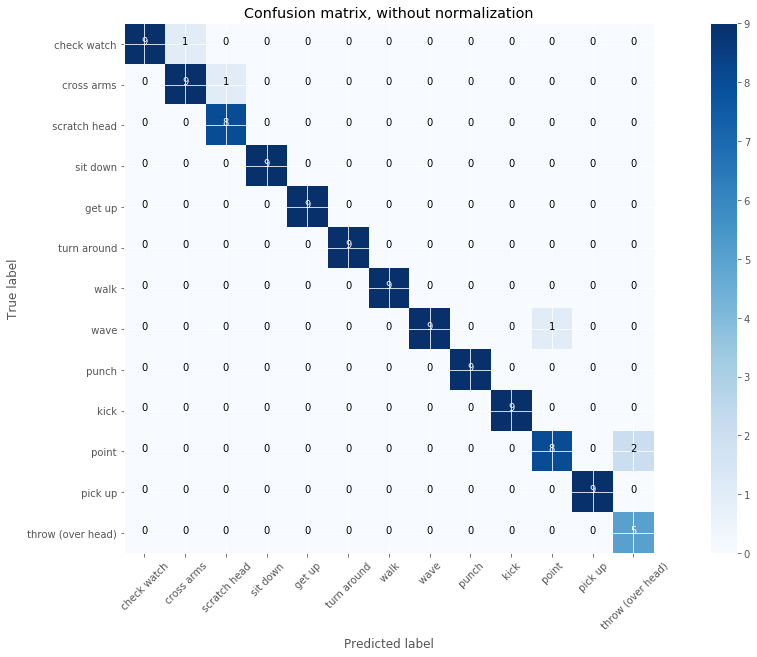

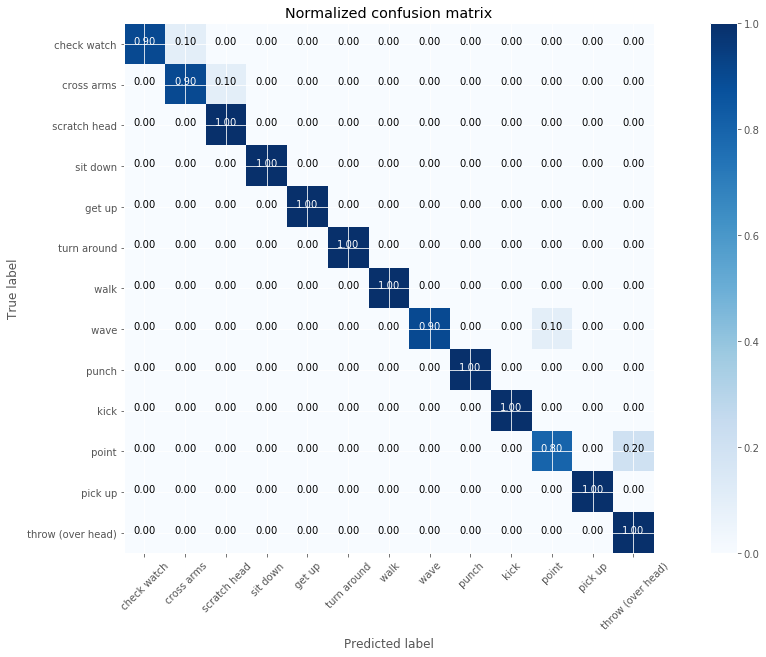

In [69]:
#function for printing the unnormalized and normalized confusion matrix ( function taken from scikit documentation ) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()